In [8]:
%matplotlib inline

In [1]:
# %load ../../pyRNAfold/utils.py
import pandas as pd
import numpy as np
from ggplot import *

def compute_prob_vector(ps_file, prob_paired=True):
    '''
    Given a text file derived from the RNAfold output of the form
    
    i    j    sqrt(prob)   ubox
    
    computes a vector (dict) of probabilities for every nucleotide
    to be in paired (or unpaired) state.
    '''
    prob_vector = {}
    with open(ps_file) as fi:
        for line in fi.readlines():
            line = line.strip()
            posi, posj, sqrt_prob, box = line.split()
            curr_i = prob_vector.get(int(posi), 0)
            curr_j = prob_vector.get(int(posj), 0)
            prob_vector.update({
                int(posi): curr_i + float(sqrt_prob)**2,
                int(posj): curr_j + float(sqrt_prob)**2,
            })
    if prob_paired:
        return prob_vector
    else:
        return dict([(pos, 1-p) for pos,p in prob_vector.items()])
    
def compute_prob_vector_max(ps_file, prob_paired=True):
    '''
    Given a text file derived from the RNAfold output of the form
    
    i    j    sqrt(prob)   ubox
    
    computes a vector (dict) of probabilities for every nucleotide
    to be in paired (or unpaired) state.
    '''
    prob_vector = {}
    with open(ps_file) as fi:
        for line in fi.readlines():
            line = line.strip()
            posi, posj, sqrt_prob, box = line.split()
            curr_i = prob_vector.get(int(posi), 0)
            curr_j = prob_vector.get(int(posj), 0)
            curr_prob = float(sqrt_prob)**2
            indi = int(posi)
            indj = int(posj)
            if prob_vector.has_key(indi):
                if curr_prob > prob_vector[indi]:
                    prob_vector[indi] = curr_prob
            else:
                prob_vector[indi] = curr_prob
            if prob_vector.has_key(indj):
                if curr_prob > prob_vector[indj]:
                    prob_vector[indj] = curr_prob
            else:
                prob_vector[indj] = curr_prob
                
    if prob_paired:
        return prob_vector
    else:
        return dict([(pos, 1-p) for pos,p in prob_vector.items()])
    

def trange_df(base_name, prob_func=compute_prob_vector, 
              trange=range(35,43), abs_value=True):
    '''
    Same as `compute_diff_df` but builds dataframe in a long format
    suitable for ggplot faceting.
    '''
    T0 = trange[0]
    prob0 = pd.Series(prob_func('%s_%d.txt' % (base_name, T0)).values())
    chunks = []
    for temp in trange[1:]:
        df = pd.DataFrame()
        prob_vector = prob_func('%s_%d.txt' % (base_name,temp))
        df['pos'] = prob_vector.keys()
        if abs_value:
            df['Diff'] = abs(pd.Series(prob_vector.values()) - prob0)
        else:
            df['Diff'] = pd.Series(prob_vector.values()) - prob0
        df['Temp'] = temp
        chunks.append(df)
    return pd.concat(chunks)

def sig_positions(df, num_sigma=6):
    mean = df['Diff'].mean()
    sigma = df['Diff'].std()
    threshold = num_sigma * sigma
    return abs(df['Diff'] - mean) > threshold


def compute_diff_df(base_name, trange=range(35,43), abs_value=True):
    '''
    Given the base_name for tab-delimited files containing base
    pairing probabilities calculated by RNAfold computes a
    dataframe containing probability difference vectors for each
    temperature value in the range relative to the lowest T in the
    range.
    '''
    T0 = trange[0]
    prob = compute_prob_vector('%s_%d.txt' % (base_name, T0))
    df = pd.DataFrame(prob.items(), columns=['Position', 'Prob_%d' % T0])
    for temp in trange[1:]:
        prob = compute_prob_vector('%s_%d.txt' % (base_name, temp))
        prob_key = 'Prob_%d' % temp
        df[prob_key] = pd.Series(prob.values())
        if abs_value:
            df['Diff_%d' % temp] = abs(df[prob_key] - df['Prob_%d' % T0])
        else:
            df['Diff_%d' % temp] = df[prob_key] - df['Prob_%d' % T0]
    return df

def get_sig_positions(df, trange=range(37,43), num_sigma=6):
    '''
    Given the dataframe of probability differences for a T range
    and the level of significannce in sigmas returns positions in the
    dataframe where the probability difference at the highest T
    exceeds the sigma threshold.
    '''
    colnames = ['Diff_%d' % temp for temp in trange[1:]]
    diff_cols = [df[colname] for colname in colnames]
    all_diff = pd.concat(diff_cols)
    mean = all_diff.mean()
    sigma = all_diff.std()
    threshold = num_sigma * sigma
    print 'Mean:\t%f\nSigma:\t%f\nThreshold:\t%f\n' % (mean, sigma, threshold)
    return df[abs(df['Diff_%d' % trange[-1]] - mean) > threshold].sort(['Position'])

def plot_RSMD(df, trange=range(37,43)):
   df_sum = pd.DataFrame()
   df_sum['Temp'] = trange[1:]
   df_sum['RMSD'] = [np.sqrt(((df[df['Temp'] == T]['Diff'])**2).sum()) for T in trange[1:]]
   p = ggplot(df_sum, aes(x='Temp', y='RMSD')) + geom_line()
   return p


In [3]:
compute_prob_vector('../data/ROSE1_25.txt')

{1: 0.9841394374089782,
 2: 0.9999162791337098,
 3: 0.9999576804477457,
 4: 0.9995141630237306,
 5: 0.9999912980189313,
 6: 0.9996765861533583,
 11: 0.9996765861533583,
 12: 0.9999912980189313,
 13: 0.9995141630237306,
 14: 0.9999576804477457,
 15: 0.9999066197468567,
 16: 0.9994760767477869,
 17: 0.9578294825477667,
 18: 0.9508862757757752,
 19: 0.590668327005271,
 20: 0.9979364797248212,
 21: 0.9989496914431278,
 22: 0.9989277116048189,
 23: 0.9999140244505464,
 24: 0.9997568629455362,
 25: 0.99893496260603,
 26: 0.000116504923076068,
 27: 0.998029450763426,
 28: 0.9984180851667915,
 29: 0.00016899247778471202,
 30: 8.389999417363598e-05,
 31: 3.9153302707599996e-05,
 33: 0.9983214914520607,
 34: 0.9980889633146786,
 35: 0.9990199487878993,
 36: 0.9998648654603987,
 37: 0.99997832485611,
 38: 0.9999726074156539,
 39: 0.999891750902219,
 40: 0.9989089633433449,
 41: 0.002805281161659025,
 42: 0.3597551588441567,
 43: 0.38970001400370696,
 44: 0.5754227304329192,
 45: 0.540698660662105

In [2]:
compute_prob_vector_max('../data/ROSE1_25.txt')

{1: 0.9840499156343959,
 2: 0.9998657105087196,
 3: 0.9999576804477457,
 4: 0.9995141630237306,
 5: 0.9999912980189313,
 6: 0.9996765861533583,
 11: 0.9996765861533583,
 12: 0.9999912980189313,
 13: 0.9995141630237306,
 14: 0.9999576804477457,
 15: 0.9998657105087196,
 16: 0.9840499156343959,
 17: 0.5398343211381459,
 18: 0.5403344632144405,
 19: 0.5398945210575226,
 20: 0.9960192435103237,
 21: 0.9979745146877215,
 22: 0.9989277116048189,
 23: 0.9998919969163239,
 24: 0.9997348195824949,
 25: 0.9988510602053833,
 26: 7.276281073254398e-05,
 27: 0.9979466191768194,
 28: 0.9982364182415525,
 29: 8.5073210508196e-05,
 30: 8.389999417363598e-05,
 31: 3.9153302707599996e-05,
 33: 0.9982364182415525,
 34: 0.9979466191768194,
 35: 0.9988510602053833,
 36: 0.9997348195824949,
 37: 0.9998919969163239,
 38: 0.9989277116048189,
 39: 0.9979745146877215,
 40: 0.9960192435103237,
 41: 0.002805281161659025,
 42: 0.3597551588441567,
 43: 0.3700935246972657,
 44: 0.5398945210575226,
 45: 0.54033446321

In [4]:
df = trange_df('../data/ROSE1', trange=range(25,37))
df

,pos,Diff,Temp
0,1,0.000488,26
1,2,0.000011,26
2,3,0.000005,26
3,4,0.000023,26
4,5,0.000002,26
5,6,0.000028,26
6,11,0.000028,26
7,12,0.000002,26
8,13,0.000023,26
9,14,0.000005,26


In [3]:
df_max = trange_df('../data/ROSE1', prob_func=compute_prob_vector_max, 
                   trange=range(25,37))
df_max

,pos,Diff,Temp
0,1,0.000510,26
1,2,0.000019,26
2,3,0.000005,26
3,4,0.000023,26
4,5,0.000002,26
5,6,0.000028,26
6,11,0.000028,26
7,12,0.000002,26
8,13,0.000023,26
9,14,0.000005,26


In [6]:
df.describe()

,pos,Diff,Temp
count,1220.000000,1.177000e+03,1220.000000
mean,59.891803,2.013781e-01,31.105738
std,33.619666,3.685712e-01,3.169191
min,1.000000,3.622868e-07,26.000000
25%,31.000000,2.495468e-04,28.000000
50%,59.000000,2.907900e-03,31.000000
75%,89.000000,7.837397e-02,34.000000
max,117.000000,9.999812e-01,36.000000


In [7]:
df['Diff'].mean()

0.20137807622023268

In [8]:
df['Diff'].std()

0.36857124706295247

In [9]:
df[df['Temp'] == 35]

,pos,Diff,Temp
0,1,0.005421,35
1,2,0.000169,35
2,3,0.000090,35
3,4,0.000290,35
4,5,0.000016,35
5,6,0.000375,35
6,7,0.999622,35
7,8,0.999939,35
8,9,0.999480,35
9,10,0.999939,35


In [10]:
g = df.groupby('Temp')
for name,group in g:
    print name
    print group

26
     pos      Diff  Temp
0      1  0.000488    26
1      2  0.000011    26
2      3  0.000005    26
3      4  0.000023    26
4      5  0.000002    26
5      6  0.000028    26
6     11  0.000028    26
7     12  0.000002    26
8     13  0.000023    26
9     14  0.000005    26
10    15  0.000014    26
11    16  0.000051    26
12    17  0.001919    26
13    18  0.002116    26
14    19  0.000922    26
15    20  0.000153    26
16    21  0.000075    26
17    22  0.000076    26
18    23  0.000008    26
19    24  0.000025    26
20    25  0.000113    26
21    26  0.000013    26
22    27  0.000216    26
23    28  0.000186    26
24    29  0.000020    26
25    30  0.000006    26
26    31  0.000003    26
27    33  0.000194    26
28    34  0.000211    26
29    35  0.000098    26
..   ...       ...   ...
77    87  0.000121    26
78    88  0.000295    26
79    89  0.010510    26
80    90  0.015277    26
81    91  0.000016    26
82    92  0.001994    26
83    93  0.000479    26
84    94  0.000824    

In [11]:
%matplotlib inline

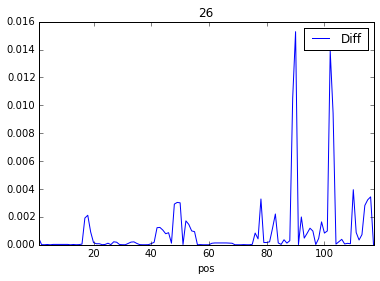

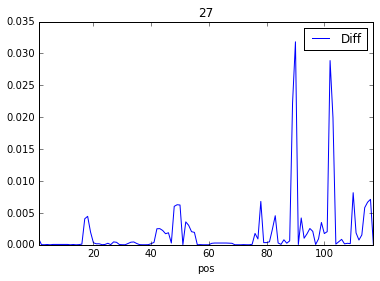

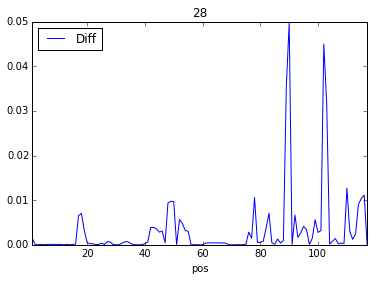

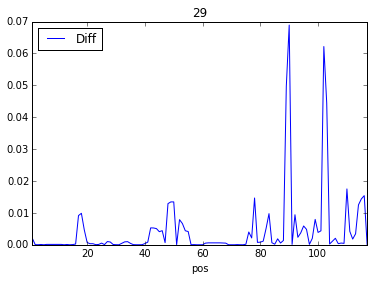

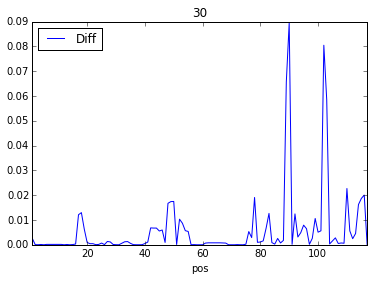

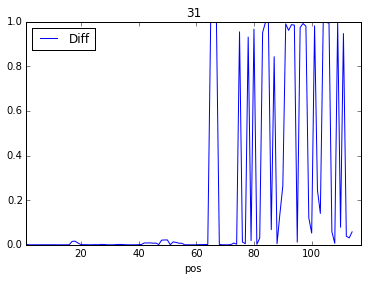

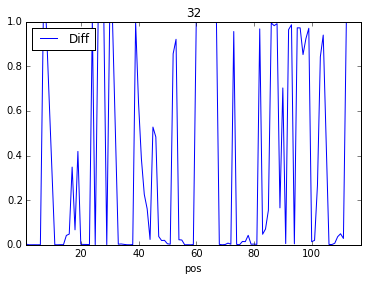

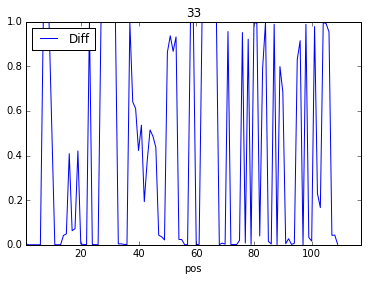

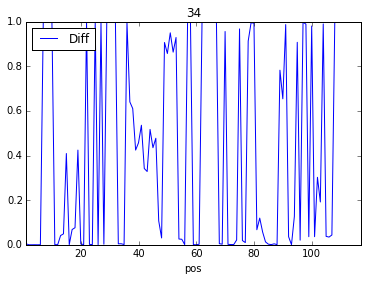

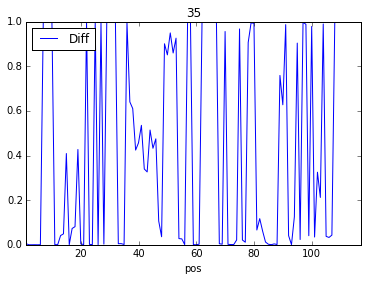

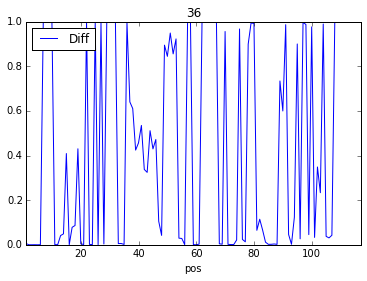

In [12]:
for name,group in g:
    group.plot(x='pos', y='Diff', title=name)

In [13]:
g = ggplot(df, aes(xmin='pos-1',xmax='pos', ymin=0, ymax='Diff')) \
    + geom_rect() \
    + facet_wrap('Temp')

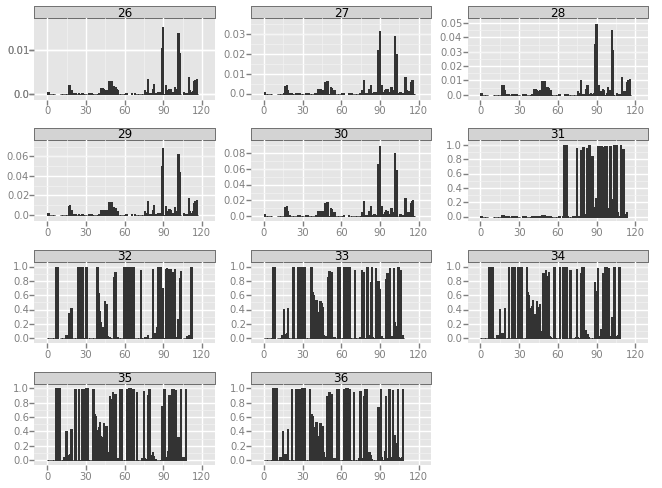

<ggplot: (8751441225861)>


In [14]:
print g

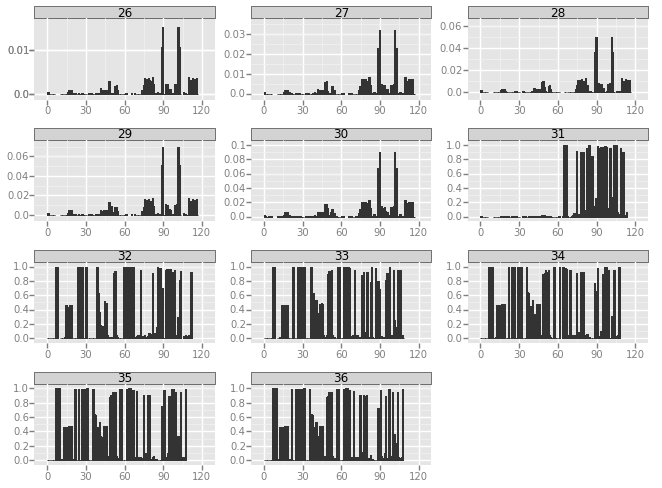

<ggplot: (8772080324921)>


In [7]:
g = ggplot(df_max, aes(xmin='pos-1',xmax='pos', ymin=0, ymax='Diff')) \
    + geom_rect() \
    + facet_wrap('Temp')
print g